# Problem Statement: **Training in Agricultural Company**

### In this chapter, you’ll explore the foundational aspects of training neural networks in AI-oriented Agricultural company. You’ll work as an AI engineer to train models that solve critical challenges in different domains. Along the way, you’ll learn about gradient descent, batch processing, and training neural networks from scratch.

References:
* Column Stack (Numpy) [link](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html)

* PyTorch Tensors (PyTorch) [link](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html)

* Sequential (PyTorch) [link](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

Imports and CUDA

In [292]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### **Task1: Predicting Equipment Costs**

The AI Agriculture Company is developing a tool to predict the cost of manufacturing its new agricultural equipment. The cost is directly proportional to the square of the material used. Your task is to compute and predict the cost, and debug the gradients of the implemented backpropagation process.

Use when required: $$ f(x) = x^2$$

**Step1:** Define the Problem

Assume the material required is represented as a single feature: **material_amount**. For simplicity:

* **Input:** material_amount (a tensor of size (1, 1)) — e.g., 5 units of material.
* **Target cost:** material_amount ** 2 — the cost of producing the equipment.

In [293]:
# Material amount as input (e.g., 5 units)
material_amount = torch.tensor([[5.0]])

# Target cost (cost = material_amount ** 2)
target_cost = material_amount**2

**Step2:** Set Up the Model

Use a single-layer linear model to predict the cost. The model should:

* Take material_amount as input.
* Output the predicted cost (scalar).

In [294]:
# Start with random weights and zero biases
torch.manual_seed(0)  # For reproducibility
weight = torch.tensor([[0.5]], requires_grad=True)  # Initialize weight manually
bias = torch.tensor([[0.0]], requires_grad=True)  # Initialize bias as zero

predicted_cost = torch.matmul(material_amount, weight) + bias

**Step3:** Compute Loss

Use Mean Squared Error **(MSE)** to calculate the loss between the predicted and actual costs.

In [295]:
# Loss function: Mean Squared Error (MSE)
loss = torch.mean((predicted_cost - target_cost) ** 2)

**Step4:** Backpropagation

* Write the gradient descent process step-by-step.
* Manually compute the gradients of the loss with respect to the model's weights and biases using the chain rule.


In [296]:
# Calculate the gradient of the loss w.r.t. predicted_cost
grad_predicted_cost = 2 * (predicted_cost - target_cost) / target_cost.size(0)  # dL/d(predicted_cost)

# Calculate the gradient of predicted_cost w.r.t. weight and bias
grad_weight = torch.matmul(material_amount.T, grad_predicted_cost) # dL/d(weight)
grad_bias = torch.sum(grad_predicted_cost)  # dL/d(bias)

**Step5:** Verify Gradients

Use **torch.autograd** to compute gradients automatically and compare them with your manual calculations.

You can use **allclose** to check whether all elements of two tensors are approximately equal, within a specified tolerance.

https://pytorch.org/docs/stable/generated/torch.allclose.html

In [297]:
# Code Here
loss.backward()

In [298]:
# Compare Gradients
print("Manual Gradients:")
print("Weight Gradient:", grad_weight.item())
print("Bias Gradient:", grad_bias.item())

print("\nAutograd Gradients:")
print("Weight Gradient:", weight.grad.item())
print("Bias Gradient:", bias.grad.item())

# Verify the Gradients
print("\nGradient Verification:")
print("Weight Gradients Match:", torch.allclose(grad_weight, weight.grad, atol=1e-6))
print("Bias Gradients Match:", torch.allclose(grad_bias, bias.grad, atol=1e-6))

Manual Gradients:
Weight Gradient: -225.0
Bias Gradient: -45.0

Autograd Gradients:
Weight Gradient: -225.0
Bias Gradient: -45.0

Gradient Verification:
Weight Gradients Match: True
Bias Gradients Match: True




---



### **Task2: Optimizing Equipment Production with Neural Networks**

The AI Agriculture Company wants to predict the efficiency of manufacturing equipment based on two input features:

* Weekly hours spent on machine maintenance
* Weekly hours spent on training factory workers.

The company believes these two factors significantly impact production efficiency, which is represented as a score between 0 and 1. Your task is to build and train a simple neural network to predict this efficiency score.

**Step 1:** Dataset Details

Simulate a dataset with the following properties:

* Feature 1: Machine Maintenance Hours (range: 5 to 50 hours).
* Feature 2: Training Hours for Workers (range: 2 to 20 hours).
* Target Output: Efficiency score calculated as:

$$ Efficiency Score= (0.4⋅Maintenance Hours+0.6⋅Training Hours)/50$$
​



In [299]:
# Complete the code here
np.random.seed(42)
n_samples = 1000
machine_maintenance_hours = np.random.uniform(5, 50, 500)  # Maintenance hours
training_hours = np.random.uniform(2, 20, 500)             # Training hours
efficiency_score =  (0.4*machine_maintenance_hours + 0.6*training_hours)/50 # Efficiency score

# Combine into a dataset
X = np.column_stack((machine_maintenance_hours, training_hours))
y = efficiency_score.reshape(-1, 1)

**Step 2**: Split the dataset into training (80%) and validation (20%) sets.

In [300]:
# Code Here
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Step3:** Normalize input features to improve training stability.

In [301]:
# Code Here
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [302]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

**Step4:** Define a neural network with the following structure:

* Input Layer: 2 neurons (for the two input features).
* Hidden Layer: 5 neurons with ReLU activation.
* Output Layer: 1 neuron with sigmoid activation (to output a value between 0 and 1).


In [303]:
model = nn.Sequential(
    nn.Linear(2, 5),  # 2 input features, 5 hidden neurons
    nn.ReLU(),        # ReLU activation
    nn.Linear(5, 1),  # 1 output neuron
    nn.Sigmoid()      # Sigmoid activation for efficiency score
)

**Step5**: Train the network using:

* **Optimizers**: SGD.
* **Epochs**: 200.
* **Learning Rates**: 0.01.

In [304]:
def train_model(model, loss_fn, optimizer, X, y, X_val, y_val, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        # Training
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = loss_fn(y_val_pred, y_val)
            
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        # Progress
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        
    return train_losses, val_losses



# Step 6: Train and evaluate the model
epochs = 500
learning_rate = 0.05

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

train_losses, val_losses = train_model(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, epochs)

Epoch 1/500, Train Loss: 0.0652, Val Loss: 0.0536
Epoch 50/500, Train Loss: 0.0301, Val Loss: 0.0326
Epoch 100/500, Train Loss: 0.0263, Val Loss: 0.0285
Epoch 150/500, Train Loss: 0.0238, Val Loss: 0.0258
Epoch 200/500, Train Loss: 0.0218, Val Loss: 0.0237
Epoch 250/500, Train Loss: 0.0201, Val Loss: 0.0220
Epoch 300/500, Train Loss: 0.0186, Val Loss: 0.0204
Epoch 350/500, Train Loss: 0.0173, Val Loss: 0.0191
Epoch 400/500, Train Loss: 0.0161, Val Loss: 0.0178
Epoch 450/500, Train Loss: 0.0151, Val Loss: 0.0167
Epoch 500/500, Train Loss: 0.0141, Val Loss: 0.0157


**Step6:**  Plot and analyze the convergence curves for training and validation loss

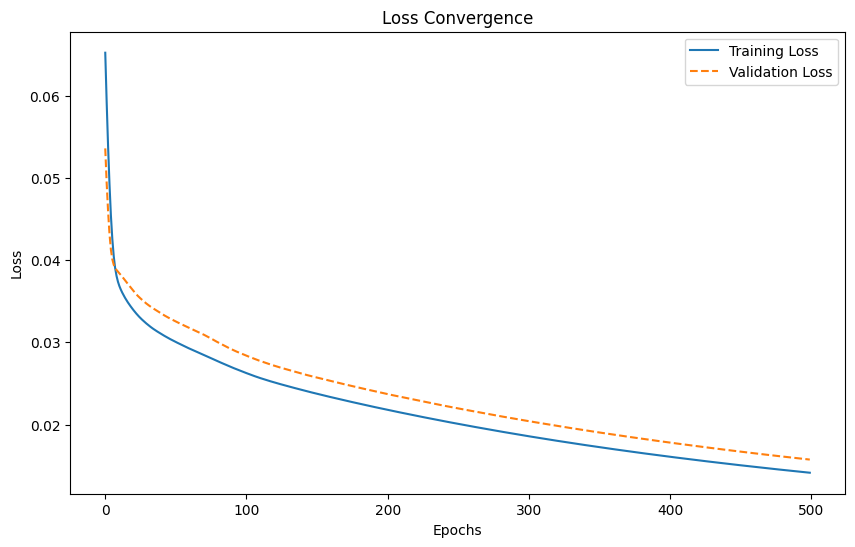

In [305]:
# Code Here
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.title("Loss Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Bonus:** Modify epochs to 500 and learning rate to 0.05 and analyse the graph



---



### **Task4: Predicting Crop Yield in AgroTech**

In AgroTech, an agriculture-focused town, farmers rely on AI systems to predict crop yields based on weather and soil data.

Your task is to build and train a neural network to predict Crop Yield (tons/ha) using features from the provided dataset **(agriculture_dataset_codebasics_DL.csv)**.

**Dataset Overview**

The agriculture_dataset.csv file contains the following features:

* Temperature (C): Average temperature during the growing season.

* Rainfall (mm): Total rainfall during the growing season.

* Soil_pH: Soil acidity (range: 0-14).

* Nitrogen (mg/kg): Nitrogen content in the soil.

* Irrigation_Hours: Total hours of irrigation during the growing season.

* Fertilizer_Usage (kg/ha): Total fertilizer used per hectare.

* Crop_Yield (tons/ha): Target variable representing the crop yield.

**Goal**

Train a neural network to predict the crop yield using Batch Gradient Descent, Mini-Batch Gradient Descent, and Stochastic Gradient Descent.

Compare their performance by plotting loss convergence over epochs.

**Step 1:** Load and split the dataset

In [306]:
# Load the dataset
df = pd.read_csv('agriculture_dataset_codebasics_DL.csv')
df.head()

# Split data into features and target
target_col = "Crop Yield (tons/ha)"   # your target column name

features = df[['Temperature (C)', 'Rainfall (mm)', 'Soil pH', 'Nitrogen (mg/kg)', 'Irrigation Hours', 'Fertilizer Usage (kg/ha)']].values
target = df['Crop Yield (tons/ha)'].values.reshape(-1, 1)


**Step 2:** Normalize the input features to a range of 0-1 and perform an **80%-20%** train-validation split.

In [307]:
# Code
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, target, test_size=0.2, random_state=42)

In [308]:
# Convert data to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

**Step 3:** Define a neural network architecture

**Input:** 6 features (Temperature, Rainfall, Soil pH, Nitrogen, Irrigation Hours, Fertilizer Usage).

**Hidden Layer:** 10 neurons with ReLU activation.

**Output:** 1 neuron with linear activation (for regression).

In [309]:
# Code Here
model = nn.Sequential(
    nn.Linear(6, 10),  # 6 input features, 10 hidden neurons
    nn.ReLU(),        # ReLU activation
    nn.Linear(10, 1),  # 1 output neuron
)

# Define the loss function
loss_fn = torch.nn.MSELoss()

**Step 4:** Train the network using

Batch Gradient Descent (GD):Update weights after processing the entire dataset.

Mini-Batch Gradient Descent: Update weights after processing batches of size 16.

Stochastic Gradient Descent (SGD): Update weights after every data point.

In [310]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 16),
            nn.ReLU(),
            nn.Linear(16, 1)   # output (batch, 1)
        )

    def forward(self, x):
        return self.net(x)


In [311]:
# Training function for different GD methods
def train_model(optimizer, X, y, epochs=50, batch_size=None):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, X.size(0), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        losses.append(epoch_loss / X.size(0))
    return losses


# Train the model using Batch GD
model = NeuralNetwork()  # Reset model
optimizer_gd = torch.optim.SGD(model.parameters(), lr=0.01)
losses_gd = train_model(optimizer_gd, X_train, y_train, 50, X_train.size(0))


# Train the model using Mini-Batch GD
model = NeuralNetwork()  # Reset model
optimizer_mbgd = torch.optim.SGD(model.parameters(), lr=0.01)
losses_mbgd = train_model(optimizer_mbgd, X_train, y_train, 50, 16)


# Train the model using Stochastic GD
model = NeuralNetwork()  # Reset model
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.01)
losses_sgd = train_model(optimizer_sgd, X_train, y_train, 50, 1)

**Step 5:** Plot the loss over epochs for each method.

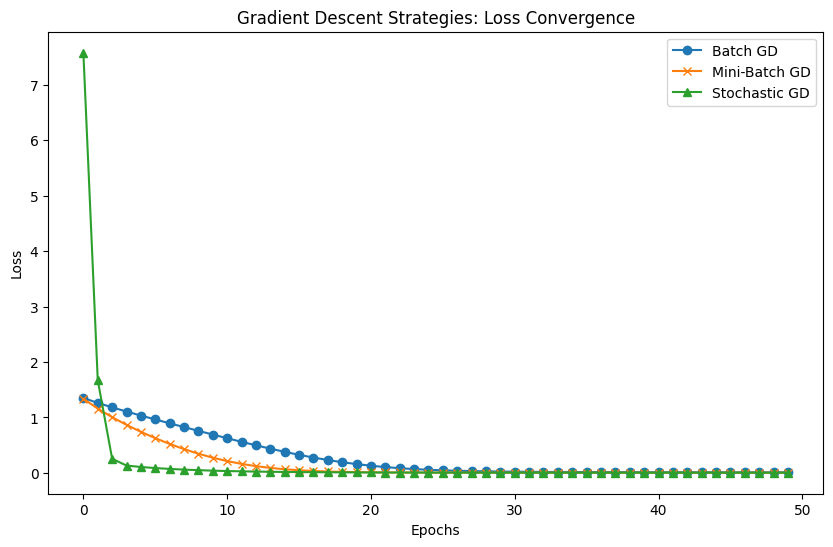

In [312]:
plt.figure(figsize=(10, 6))
plt.plot(losses_gd, label='Batch GD', marker='o')
plt.plot(losses_mbgd, label='Mini-Batch GD', marker='x')
plt.plot(losses_sgd, label='Stochastic GD', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gradient Descent Strategies: Loss Convergence')
plt.legend()
plt.show()

**Step 6:** Evaluate the model's Mean Squared Error (MSE) on the validation set.

In [313]:
with torch.no_grad():
    y_val_pred = model(X_val)
    mse = loss_fn(y_val_pred, y_val).item()
    print("Validation Mean Squared Error (MSE):", mse)


Validation Mean Squared Error (MSE): 0.008563696406781673
